In [47]:
!pip install geopandas matplotlib shapely cdsapi numpy xarray rioxarray netcdf4 scipy pandas catboost scikit-learn

  Using cached scikit_learn-1.3.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.2.0-py3-none-any.whl.metadata (10.0 kB)
Using cached scikit_learn-1.3.2-cp311-cp311-macosx_12_0_arm64.whl (9.4 MB)
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Using cached threadpoolctl-3.2.0-py3-none-any.whl (15 kB)


In [48]:
import geopandas as gpd
import ast
import shapely
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import catboost

In [3]:
def convert_gee_geo(row):
    le = ast.literal_eval(row['.geo'])
    return shapely.Polygon(le['coordinates'][0])

def read_gsw_file(loc):
    df = gpd.read_file(loc)
    df.columns = ['system:index',
     'COAST',
     'DIST_MAIN',
     'DIST_SINK',
     'ENDO',
     'HYBAS_ID',
     'MAIN_BAS',
     'NEXT_DOWN',
     'NEXT_SINK',
     'ORDER',
     'PFAF_ID',
     'SORT',
     'SUB_AREA',
     'UP_AREA',
     'water_balance',
     '.geo',
     'geometry']
    df['SUB_AREA'] = df.SUB_AREA.apply(float)
    df['.geo'] = df.apply(convert_gee_geo, axis=1)
    df.set_geometry('.geo', inplace=True)
    df.set_crs("EPSG:4326", inplace=True)
    df['water_balance'] = df.water_balance.astype(float) * df.SUB_AREA

    return df

In [4]:
# df = gpd.read_file('data/diff_hb_2010.csv')
# # df.set_geometry('.geo', inplace=True)
# df.columns = ['system:index',
#  'COAST',
#  'DIST_MAIN',
#  'DIST_SINK',
#  'ENDO',
#  'HYBAS_ID',
#  'MAIN_BAS',
#  'NEXT_DOWN',
#  'NEXT_SINK',
#  'ORDER',
#  'PFAF_ID',
#  'SORT',
#  'SUB_AREA',
#  'UP_AREA',
#  'water_balance',
#  '.geo',
#  'geometry']
# df['SUB_AREA'] = df.SUB_AREA.apply(float)

# def convert_gee_geo(row):
#     le = ast.literal_eval(row['.geo'])
#     return shapely.Polygon(le['coordinates'][0])

# df['.geo'] = df.apply(convert_gee_geo, axis=1)
# df.set_geometry('.geo', inplace=True)
# df.set_crs("EPSG:4326", inplace=True)
# ''
df = read_gsw_file(loc='data/diff_hb_2010.csv')

In [5]:
# df.crs

In [6]:
# df.head()

In [7]:
# df['water_balance'] = df.water_balance.astype(float) * df.SUB_AREA # 30m by 30m pixels / 

<Axes: >

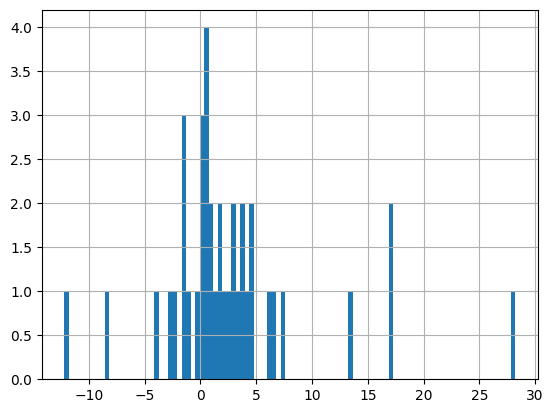

In [8]:
df.water_balance.hist(bins=100)

<Axes: >

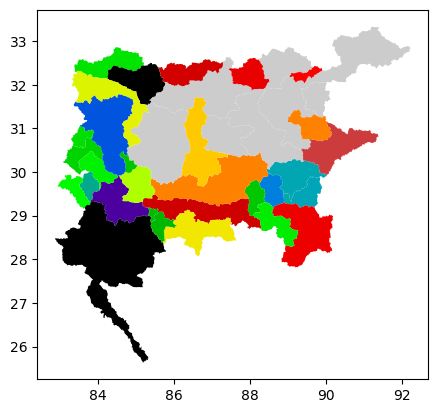

In [9]:
df.plot('water_balance', cmap='nipy_spectral', vmin=-5, vmax=5)


In [10]:
downloaded = True

if downloaded == False:

    import cdsapi

    c = cdsapi.Client()

    years = np.arange(2012, 2022, 1)
    days = [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ]
    months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    times = '23:00'
    area = [45, 68, 24, 107]

    for year in years:
        year = str(year)
        c.retrieve('reanalysis-era5-land', {'year':year, 'month':months, 'time':times, 'day':days, 'area':area
                                           ,'variable':'total_precipitation', 'format':'netcdf.zip'}
                  ,'precip-'+year+'netcdf.zip')

# now we need to unzip the data
if downloaded == False:
    import glob
    import shutil
    for f in glob.glob('data/precip/*'):
        unzipped_filename = f.split('-')[1][0:4]
        shutil.unpack_archive(f, unzipped_filename)

In [33]:
def read_precip_data(year):
    precip = xr.open_dataset(f'data/precip/{year}data.nc')
    precip_plusone = xr.open_dataset(f'data/precip/{year}data.nc')
    precips = xr.concat([precip, precip_plusone], dim=['longitude', 'latitude'])
    return precips

def get_mean_std(gsw, precip):
    precip = precip.rio.write_crs(gsw.crs)
    means = [precip.rio.clip([poly], gsw.crs).tp.mean().item() for poly in gsw['.geo'].values]
    stdev = [precip.rio.clip([poly], gsw.crs).tp.std().item() for poly in gsw['.geo'].values]
    gsw['precip_means'] = means
    gsw['precip_stdev'] = stdev
    return gsw

In [34]:
# years = np.arange(2000, 2022, 1)
years = np.arange(2000, 2012, 1)
dfs = []
for year in years:
    gsw_data = read_gsw_file(loc=f'data/diff_hb_{year}.csv')
    precip = read_precip_data(year=year)
    gsw_data = get_mean_std(gsw=gsw_data, precip=precip)
    gsw_data['year'] = year
    dfs.append(gsw_data)

In [35]:
df = pd.concat(dfs)

In [36]:
df

,system:index,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,MAIN_BAS,NEXT_DOWN,NEXT_SINK,ORDER,PFAF_ID,SORT,SUB_AREA,UP_AREA,water_balance,.geo,geometry,precip_means,precip_stdev,year
0,000000000000000017e6,0,2331.1,2331.1,0,4060788280,4060025450,4060786650,4060025450,1,452973,1270,3752.1,109042.1,-1.898470,"POLYGON ((89.08298 29.29755, 89.08368 29.29341...",None,0.002083,0.003257,2000
1,000000000000000017e7,0,2413.2,2413.2,0,4060787190,4060025450,4060788280,4060025450,1,452975,1276,415.0,97861.7,-2.202417,"POLYGON ((88.87860 29.47575, 88.87973 29.46446...",None,0.002045,0.003483,2000
2,000000000000000017e8,0,2439.8,2439.8,0,4060787530,4060025450,4060787190,4060025450,1,452977,1278,3658.4,83214.7,-4.651820,"POLYGON ((88.24583 29.74583, 88.24619 29.73921...",None,0.002326,0.003757,2000
3,000000000000000017e9,0,2497.1,2497.1,0,4060787180,4060025450,4060787530,4060025450,1,452979,1283,2983.2,74088.8,-0.602387,"POLYGON ((87.86667 29.57083, 87.86723 29.55612...",None,0.002165,0.003640,2000
4,000000000000000017ea,0,2554.1,2554.1,0,4060785160,4060025450,4060787180,4060025450,1,452991,1286,12286.5,51219.8,-6.918297,"POLYGON ((85.17464 29.25171, 85.17535 29.24757...",None,0.002161,0.004017,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,00000000000000000544,0,0.0,0.0,2,4060053240,4060053240,0,4060053240,1,491505,2365,4103.1,4103.1,-3.839760,"POLYGON ((89.35000 31.90833, 89.35057 31.89779...",None,0.001473,0.002609,2011
35,00000000000000000545,0,0.0,0.0,2,4060053250,4060053250,0,4060053250,1,491404,2366,3511.5,3511.5,-1.533982,"POLYGON ((84.64110 31.09658, 84.64223 31.09362...",None,0.001406,0.003275,2011
36,0000000000000000055a,0,0.0,0.0,2,4060054270,4060054270,0,4060054270,1,491401,2396,1734.2,1734.2,-0.741303,"POLYGON ((83.30382 30.75662, 83.30832 30.75208...",None,0.001457,0.002754,2011
37,00000000000000000578,0,0.0,0.0,2,4060056500,4060056500,0,4060056500,1,491405,2442,996.7,996.7,-0.278628,"POLYGON ((84.57500 30.40000, 84.57535 30.39758...",None,0.001589,0.003125,2011


<Axes: xlabel='precip_means', ylabel='water_balance'>

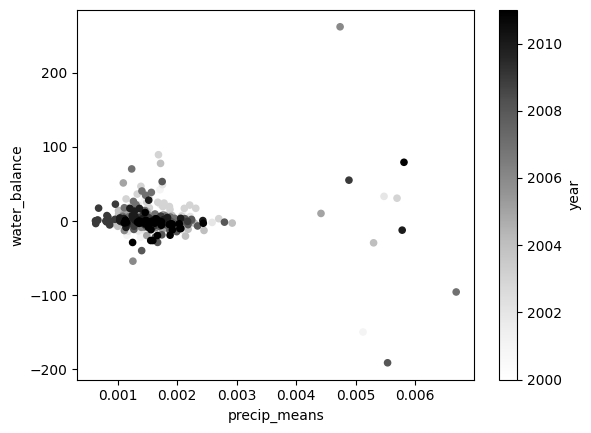

In [38]:
fig, ax = plt.subplots()

df.plot.scatter('precip_means', 'water_balance', c='year', ax=ax)
# ax.set_xlim(0, 0.004)
# ax.set_ylim(-50, 50)

In [ ]:
df

In [40]:
df.columns
cb_columns = [ 'ENDO', 'SUB_AREA', 'water_balance', 
       'precip_means', 'precip_stdev', 'year']

Index(['system:index', 'COAST', 'DIST_MAIN', 'DIST_SINK', 'ENDO', 'HYBAS_ID',
       'MAIN_BAS', 'NEXT_DOWN', 'NEXT_SINK', 'ORDER', 'PFAF_ID', 'SORT',
       'SUB_AREA', 'UP_AREA', 'water_balance', '.geo', 'geometry',
       'precip_means', 'precip_stdev', 'year'],
      dtype='object')

In [43]:
df['year'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011])

In [61]:
df.columns

Index(['system:index', 'COAST', 'DIST_MAIN', 'DIST_SINK', 'ENDO', 'HYBAS_ID',
       'MAIN_BAS', 'NEXT_DOWN', 'NEXT_SINK', 'ORDER', 'PFAF_ID', 'SORT',
       'SUB_AREA', 'UP_AREA', 'water_balance', '.geo', 'geometry',
       'precip_means', 'precip_stdev', 'year'],
      dtype='object')

In [62]:
# import pandas as pd
from catboost import CatBoostRegressor
# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

cols = ['COAST', 'DIST_MAIN', 'DIST_SINK', 'ENDO', 
        'SUB_AREA', 'UP_AREA', 'precip_means', 'precip_stdev', 'year']

# Assuming 'df' is your DataFrame
# Prepare your features and target variables
X = df[cols]
y = df['water_balance']

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = df[df['year']<=2007]
test = df[df['year']>2007]

X_train = train[cols]
y_train = train['water_balance']

X_test = test[cols]
y_test = test['water_balance']

# Initialize CatBoost Regressor
# Specify the categorical features; they are assumed to be of object type
# categorical_features_indices = np.where(X_train.dtypes == np.object)[0]
model = CatBoostRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate the model
predictions = model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)

print(f'RMSE: {rmse}')


Learning rate set to 0.034061
0:	learn: 22.9404702	total: 1.39ms	remaining: 1.38s
1:	learn: 22.7833632	total: 1.9ms	remaining: 949ms
2:	learn: 22.6719686	total: 2.36ms	remaining: 783ms
3:	learn: 22.5542553	total: 2.9ms	remaining: 722ms
4:	learn: 22.3871766	total: 3.37ms	remaining: 671ms
5:	learn: 22.2631860	total: 3.82ms	remaining: 633ms
6:	learn: 22.1449792	total: 4.25ms	remaining: 603ms
7:	learn: 21.9874061	total: 4.68ms	remaining: 580ms
8:	learn: 21.8417931	total: 5.16ms	remaining: 568ms
9:	learn: 21.7641751	total: 5.7ms	remaining: 565ms
10:	learn: 21.6833651	total: 6.11ms	remaining: 550ms
11:	learn: 21.6517606	total: 6.34ms	remaining: 522ms
12:	learn: 21.5308291	total: 6.93ms	remaining: 526ms
13:	learn: 21.3894412	total: 7.53ms	remaining: 531ms
14:	learn: 21.2904609	total: 8.05ms	remaining: 529ms
15:	learn: 21.1781283	total: 8.51ms	remaining: 523ms
16:	learn: 21.0788673	total: 9.01ms	remaining: 521ms
17:	learn: 20.9515276	total: 9.42ms	remaining: 514ms
18:	learn: 20.8134631	total: 

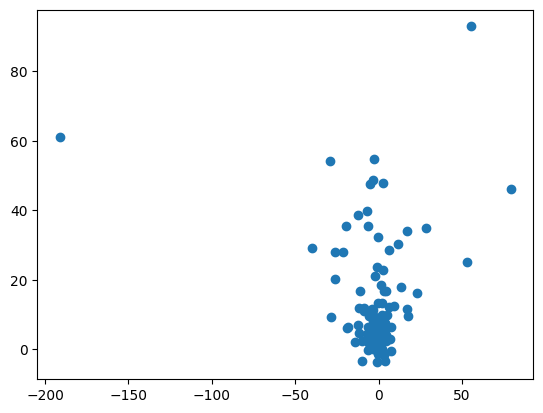

In [63]:
fig, ax = plt.subplots()

ax.scatter(y_test, predictions)
# ax.set_ylim(-10, 10)
# ax.set_xlim(-50, 50)

,COAST,DIST_MAIN,DIST_SINK,ENDO,SUB_AREA,UP_AREA,precip_means,precip_stdev,year
COAST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DIST_MAIN,NaN,1.000000e+00,9.518892e-01,-8.972864e-01,-2.139234e-01,3.563838e-01,0.122649,0.081238,1.994585e-14
DIST_SINK,NaN,9.518892e-01,1.000000e+00,-9.476004e-01,-1.633772e-01,3.961008e-01,0.146111,0.113979,1.964499e-14
ENDO,NaN,-8.972864e-01,-9.476004e-01,1.000000e+00,-2.089489e-03,-4.740790e-01,-0.365145,-0.328859,-2.059210e-14
SUB_AREA,NaN,-2.139234e-01,-1.633772e-01,-2.089489e-03,1.000000e+00,6.898169e-02,0.594589,0.594091,8.627756e-15
UP_AREA,NaN,3.563838e-01,3.961008e-01,-4.740790e-01,6.898169e-02,1.000000e+00,0.299597,0.213229,1.634551e-14
precip_means,NaN,1.226495e-01,1.461107e-01,-3.651447e-01,5.945893e-01,2.995973e-01,1.000000,0.963842,-8.233518e-02
precip_stdev,NaN,8.123788e-02,1.139794e-01,-3.288586e-01,5.940911e-01,2.132293e-01,0.963842,1.000000,-3.361139e-02
year,NaN,1.994585e-14,1.964499e-14,-2.059210e-14,8.627756e-15,1.634551e-14,-0.082335,-0.033611,1.000000e+00


In [15]:
# df['precip_means'] = means
# df['precip_stdev'] = stdev

In [16]:
# [c for c in df.columns]
# cols = ['DIST_MAIN',
#  'DIST_SINK',
#  'ENDO',
#  'SUB_AREA',
#  'water_balance',
#  'precip_means',
#  'precip_stdev']

In [17]:
# df[cols].corr()

In [18]:
# df.shape

In [19]:
# df.plot.scatter('precip_stdev', 'water_balance')

In [20]:
# time to add more data...